In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import *
from src.preprocess.dataset import Dataset
from src.preprocess.result import ResultData
import numpy as np
import lasso as mml
import pandas as pd
from sklearn.metrics import mean_squared_error

dataset_names: Optional[List[str]]

result_data = ResultData(
    datadict = True, # Optional[Dict[str, pd.DataFrame]]
    ml_ready = True, # Optional[pd.DataFrame]
    metadata = True  # Optional["Metadata"]
    )

dataset = Dataset()

result_data = dataset.get(result_data)
ml_data : pd.DataFrame = result_data.ml_ready

In [2]:
ml_data.head()

,date,country,fdi_net_inflows_current_usd,net_trade_in_goods_and_services_current_usd,consumer_price_index_change,unemployment_rate_percent_of_total_labor_force,gdp_current_usd,individuals_using_the_internet_percent_of_population,life_expectancy_at_birth_total_years,economic_activity,...,gdp_per_person_employed_constant_2011_ppp_usd,petroleum_energy_production,coal_energy_production,renewables_excluding_hydro_share,hydro_electric_energy_production,gas_energy_production,area,education_years,manufacturing_value_added_percent_of_gdp,services_value_added_percent_of_gdp
0,2000-01-01,afghanistan,170000.0,-5.162252e+09,63.523396,7.935000,3.521418e+09,0.00472,55.005001,47.602001,...,7550.477539,6.462682,0.0,0.000000,93.537315,0.000000,652860.0,6.0,18.822752,36.151154
1,2000-01-01,albania,143000000.0,-8.082604e+08,74.137474,19.023001,3.480355e+09,0.11400,74.825996,66.624001,...,18898.984375,3.850984,0.0,0.000000,96.149017,0.000000,28750.0,4.0,4.317846,44.302963
2,2000-01-01,algeria,280100000.0,1.166000e+10,70.438126,29.770000,5.479040e+10,0.49200,70.575996,46.946999,...,56081.605469,3.041870,0.0,0.000000,0.212498,96.745628,2381740.0,6.0,44.980396,33.110546
3,2000-01-01,angola,878620032.0,1.355564e+09,2.909082,16.681999,9.129595e+09,0.10500,46.500999,77.855003,...,17119.777344,36.885815,0.0,-0.810381,63.114185,12.456747,1246700.0,4.0,2.890163,22.212355
4,2000-01-01,armenia,104188496.0,-5.335268e+08,65.000587,11.095000,1.911564e+09,1.30000,72.880486,69.431999,...,11330.750000,0.000000,0.0,0.001678,21.164820,45.182949,29740.0,3.0,9.424759,45.698933


# Ideia da lag regression:
- Vamos treinar um modelo da seguinte forma:
$$
Y_t = \beta_0 + \beta_1 X1_{t-1} + \beta_2 X1_{t-1} + ... + \beta_{n} X1_{t-n} + \beta_{n+1} X2_{t-1} + ... + \epsilon
$$

Ou seja, treinaremos o modelo para predizer daqui 1 ano qual o valor daquele indíce macroeconômico. Na regressão também será adicionada termos não lineares para as covariáveis (não os parâmetros), isto é $X1^2$, $log(X1)$ etc.

Se quisermos predizer mais de 1 ano, usamos o output dessa regressão e consideramos o tempo dela como Y_t

In [3]:
ml_data['date'] = pd.to_datetime(ml_data['date'])

In [4]:
ml_data.head()

,date,country,fdi_net_inflows_current_usd,net_trade_in_goods_and_services_current_usd,consumer_price_index_change,unemployment_rate_percent_of_total_labor_force,gdp_current_usd,individuals_using_the_internet_percent_of_population,life_expectancy_at_birth_total_years,economic_activity,...,gdp_per_person_employed_constant_2011_ppp_usd,petroleum_energy_production,coal_energy_production,renewables_excluding_hydro_share,hydro_electric_energy_production,gas_energy_production,area,education_years,manufacturing_value_added_percent_of_gdp,services_value_added_percent_of_gdp
0,2000-01-01,afghanistan,170000.0,-5.162252e+09,63.523396,7.935000,3.521418e+09,0.00472,55.005001,47.602001,...,7550.477539,6.462682,0.0,0.000000,93.537315,0.000000,652860.0,6.0,18.822752,36.151154
1,2000-01-01,albania,143000000.0,-8.082604e+08,74.137474,19.023001,3.480355e+09,0.11400,74.825996,66.624001,...,18898.984375,3.850984,0.0,0.000000,96.149017,0.000000,28750.0,4.0,4.317846,44.302963
2,2000-01-01,algeria,280100000.0,1.166000e+10,70.438126,29.770000,5.479040e+10,0.49200,70.575996,46.946999,...,56081.605469,3.041870,0.0,0.000000,0.212498,96.745628,2381740.0,6.0,44.980396,33.110546
3,2000-01-01,angola,878620032.0,1.355564e+09,2.909082,16.681999,9.129595e+09,0.10500,46.500999,77.855003,...,17119.777344,36.885815,0.0,-0.810381,63.114185,12.456747,1246700.0,4.0,2.890163,22.212355
4,2000-01-01,armenia,104188496.0,-5.335268e+08,65.000587,11.095000,1.911564e+09,1.30000,72.880486,69.431999,...,11330.750000,0.000000,0.0,0.001678,21.164820,45.182949,29740.0,3.0,9.424759,45.698933


In [5]:
ml_data['year'] = pd.to_datetime(ml_data['date']).dt.year

# Agrupar por ano e calcular a média global de cada coluna numérica
data_yearly = ml_data.groupby('year').mean(numeric_only=True).reset_index()


In [6]:
#Se quiser chamar um país específico
#nome_do_pais_2 = "United States" 
#dados_do_pais_2 = dataset.get_country_data(nome_do_pais_2)

In [7]:
data_yearly.shape

(25, 21)

In [8]:
data_yearly.tail()

,year,fdi_net_inflows_current_usd,net_trade_in_goods_and_services_current_usd,consumer_price_index_change,unemployment_rate_percent_of_total_labor_force,gdp_current_usd,individuals_using_the_internet_percent_of_population,life_expectancy_at_birth_total_years,economic_activity,population_size,...,gdp_per_person_employed_constant_2011_ppp_usd,petroleum_energy_production,coal_energy_production,renewables_excluding_hydro_share,hydro_electric_energy_production,gas_energy_production,area,education_years,manufacturing_value_added_percent_of_gdp,services_value_added_percent_of_gdp
20,2020,7.171406e+09,3.166648e+09,194.809235,8.026329,5.273786e+11,64.418167,72.294289,66.158295,46300612.0,...,54137.375000,17.925570,13.037364,11.006170,28.541809,25.276148,832218.0000,5.683544,11.928063,56.342812
21,2021,1.464856e+10,5.452051e+09,306.470764,7.743462,6.019381e+11,67.926643,71.529518,66.707718,46662168.0,...,56673.570312,17.672335,12.625201,11.453166,28.749231,24.817648,832180.9375,5.683544,12.166687,54.375736
22,2022,1.108679e+10,4.314522e+09,514.787476,6.923032,6.253200e+11,69.780602,72.905357,67.389915,47047044.0,...,57199.292969,17.828711,12.674028,11.453166,28.231344,24.011042,832147.3125,5.683544,12.347533,53.600574
23,2023,4.490905e+09,5.029121e+09,563.432922,6.696342,6.534121e+11,71.253860,73.679672,67.498940,47441604.0,...,57427.140625,17.745829,12.110269,11.453166,28.379017,23.744658,832147.3125,5.677215,12.015377,54.884857
24,2024,4.562204e+09,5.029121e+09,576.600952,6.658304,6.534121e+11,71.313988,73.679672,67.525040,47441604.0,...,57427.140625,17.745829,12.110269,11.453166,28.379017,23.744658,832147.3125,5.677215,12.015377,54.884857


In [9]:
FILE_PATH = 'data_yearly.csv'
TARGET_VARIABLE = 'gdp_current_usd' # <--- ESCOLHA A COLUNA QUE VOCÊ QUER PREVER!
TRAIN_LIMIT_YEAR = 2018
LASSO_PARAMS = {'cv': 5, 'max_iter': 100000, 'n_jobs': -1, 'tol': 0.001, 'n_alphas': 10000}
# my_alphas = np.linspace(0.05, 1.0, 1000) # 100 alfas entre 0.05 e 1.0

print(f"Arquivo de Dados: {FILE_PATH}")
print(f"Variável Alvo:    {TARGET_VARIABLE}")
print(f"Ano Limite Treino:{TRAIN_LIMIT_YEAR}")

Arquivo de Dados: data_yearly.csv
Variável Alvo:    gdp_current_usd
Ano Limite Treino:2018


Dados carregados de 'data_yearly.csv'.
Removendo colunas 'Unnamed': ['Unnamed: 0']
Usando 'year' como índice.

Iniciando Engenharia de Atributos...
   - Lags e Termos Polinomiais (grau 2 e 3) criados.
   - Valores ausentes/infinitos removidos (1 linhas).
Engenharia concluída. X: (24, 40), y: (24,)

Dividindo dados em 2018 e normalizando...
   - Treino: 18, Teste: 6
Divisão e normalização concluídas.

Dividindo dados em 2018 e normalizando...
   - Treino: 18, Teste: 6
Divisão e normalização concluídas.

Treinando o Modelo LassoCV...
Treinamento concluído. Melhor Alpha (α): 0.001759

Avaliando o Modelo...
--- Resultados da Avaliação ---
   --- Escala Normalizada ---
      - EQM (MSE):  0.1525
      - REQM (RMSE): 0.3905

   --- Escala Original ---
      - EQM (MSE):  1,579,147,120,862,785,437,696.00
      - REQM (RMSE): 39,738,484,128.90
      - MAPE:       4.88%

Analisando os Coeficientes do Modelo...

--- Atributos Selecionados pelo Lasso ---
                                          

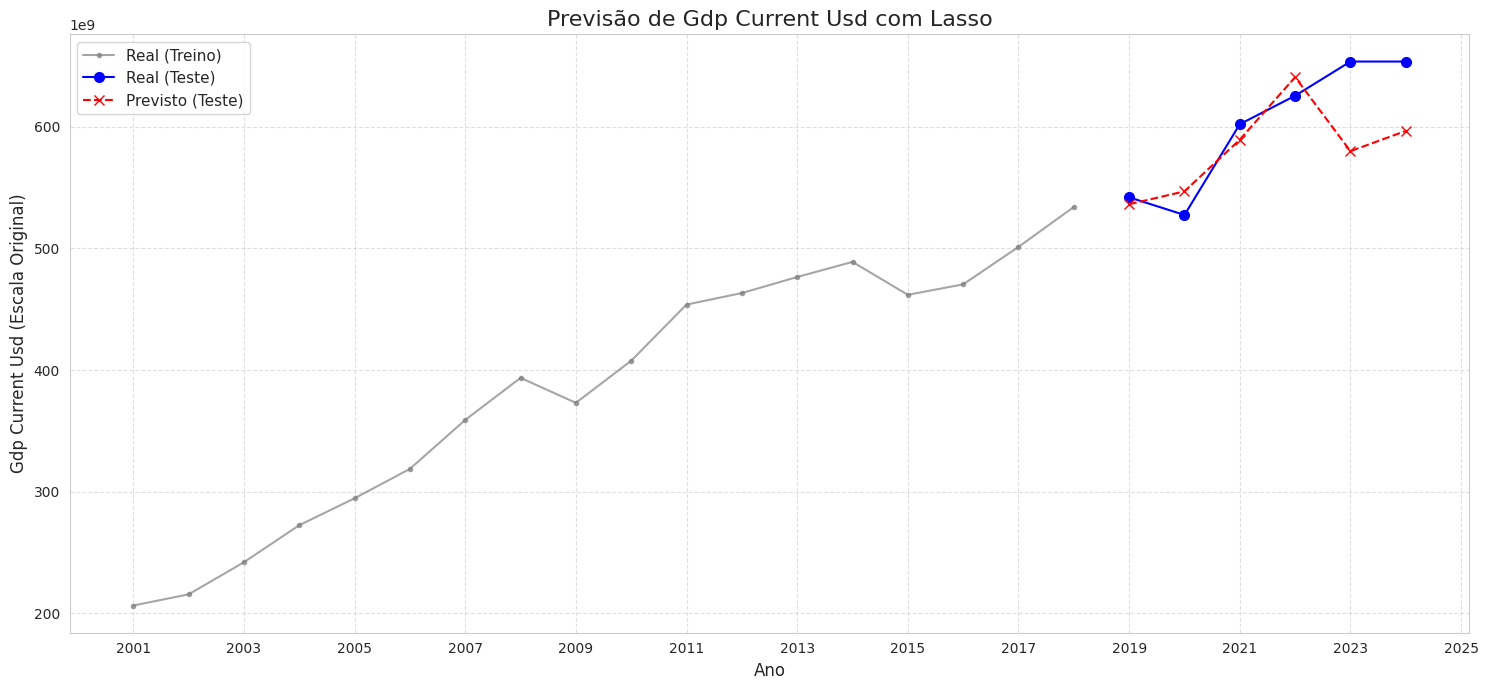


Gerando Gráfico: Importância dos Atributos...


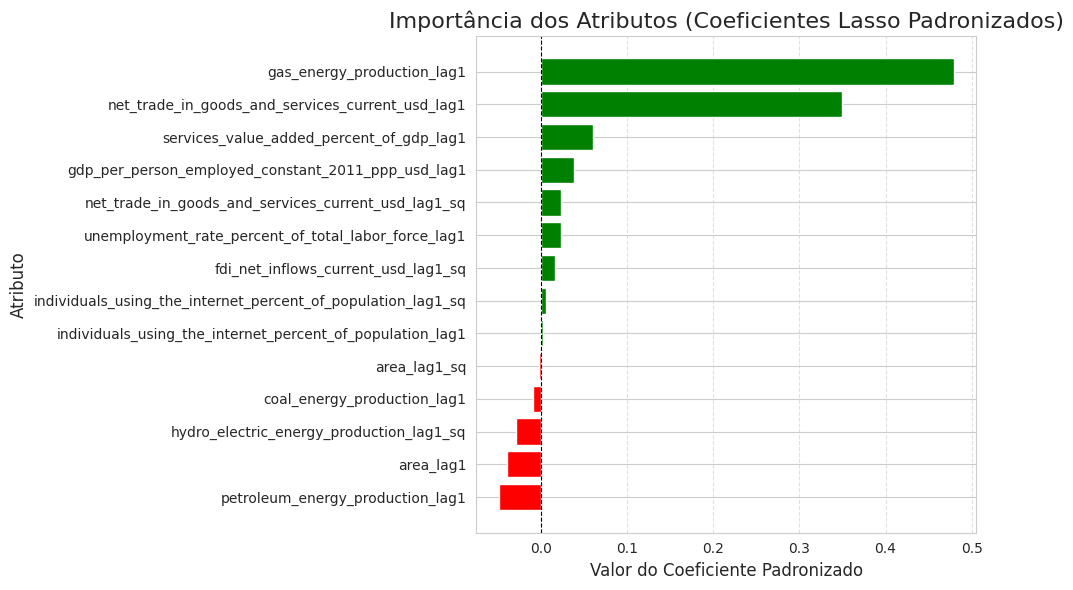

In [10]:
data = mml.load_and_prepare_data(FILE_PATH)
X, y = mml.engineer_features(data, TARGET_VARIABLE)

# 3. Divisão e Normalização (só continua se X, y foram criados)

split_result = mml.split_and_scale_data(X, y, TRAIN_LIMIT_YEAR)

# 4. Treinamento (só continua se a divisão funcionou)
(X_train_s, X_test_s, y_train_s, y_test_s,
 y_train, y_test, x_scaler, y_scaler) = mml.split_and_scale_data(X, y, TRAIN_LIMIT_YEAR)
model = mml.train_lasso_model(X_train_s, y_train_s, **LASSO_PARAMS)
# model = mml.train_lasso_model_guided_cv(X_train_s, y_train_s, alpha_list=my_alphas, **LASSO_PARAMS)

# 5. Avaliação
y_pred, metrics = mml.evaluate_model(model, X_test_s, y_test, y_test_s, y_scaler)# 6. Visualização e Coeficientes
mml.display_coefficients(model, X.columns)
mml.plot_predictions(y_train, y_test, y_pred, TARGET_VARIABLE)
mml.plot_coefficients(model, X.columns)

## Criando dataset por país


In [12]:
data_albania = dataset.get_country_data('albania')

data_albania.head()

,year,fdi_net_inflows_current_usd,net_trade_in_goods_and_services_current_usd,consumer_price_index_change,unemployment_rate_percent_of_total_labor_force,gdp_current_usd,individuals_using_the_internet_percent_of_population,life_expectancy_at_birth_total_years,economic_activity,population_size,...,gdp_per_person_employed_constant_2011_ppp_usd,petroleum_energy_production,coal_energy_production,renewables_excluding_hydro_share,hydro_electric_energy_production,gas_energy_production,area,education_years,manufacturing_value_added_percent_of_gdp,services_value_added_percent_of_gdp
0,2000,143000000.0,-8.082604e+08,74.137474,19.023001,3.480355e+09,0.114,74.825996,66.624001,3089027.0,...,18898.984375,3.850984,0.0,0.000000,96.149017,0.0,28750.0,4.0,4.317846,44.302963
1,2001,207300000.0,-9.344092e+08,76.441360,18.570000,3.922101e+09,0.326,75.083000,66.252998,3060173.0,...,20563.236328,4.691689,0.0,0.003753,95.308311,0.0,28750.0,4.0,4.099040,44.943020
2,2002,135000000.0,-1.158057e+09,82.381256,17.891001,4.348068e+09,0.390,75.299004,66.171997,3051010.0,...,21256.332031,6.046014,0.0,0.007223,93.953987,0.0,28750.0,4.0,4.066543,43.776516
3,2003,178036400.0,-1.421156e+09,82.779984,16.985001,5.611496e+09,0.972,75.556999,65.238998,3039616.0,...,22424.271484,2.143430,0.0,0.005409,97.856567,0.0,28750.0,4.0,4.124160,41.911476
4,2004,341285120.0,-1.624606e+09,84.667381,16.306000,7.184686e+09,2.420,75.950996,64.299004,3026939.0,...,23740.142578,2.497324,0.0,0.004816,97.502678,0.0,28750.0,4.0,4.177557,42.580418


In [13]:
data_albania.isna().sum()

year                                                    0
fdi_net_inflows_current_usd                             0
net_trade_in_goods_and_services_current_usd             0
consumer_price_index_change                             0
unemployment_rate_percent_of_total_labor_force          0
gdp_current_usd                                         0
individuals_using_the_internet_percent_of_population    0
life_expectancy_at_birth_total_years                    0
economic_activity                                       0
population_size                                         0
total_population                                        0
gdp_per_person_employed_constant_2011_ppp_usd           0
petroleum_energy_production                             0
coal_energy_production                                  0
renewables_excluding_hydro_share                        0
hydro_electric_energy_production                        0
gas_energy_production                                   0
area          

In [14]:
data_albania.to_csv("data_albania.csv")

In [15]:
data_brazil = dataset.get_country_data('brazil')

data_brazil.to_csv("data_brazil.csv")

## Testando um país no modelo treinado com a média global



Iniciando Previsão para Novos Dados: 'data_albania.csv'

Dados carregados de 'data_albania.csv'.
Removendo colunas 'Unnamed': ['Unnamed: 0']
Usando 'year' como índice.

Iniciando Engenharia de Atributos...
   - Lags e Termos Polinomiais (grau 2 e 3) criados.
   - Valores ausentes/infinitos removidos (1 linhas).
Engenharia concluída. X: (24, 40), y: (24,)

Alinhamento de colunas concluído. X_new_aligned: (24, 40)
Novos dados normalizados.
Previsões (escaladas) realizadas.

--- Previsões Finais (Escala Original) ---
year
2001    3.279661e+12
2002    3.281548e+12
2003    3.274106e+12
2004    3.240707e+12
2005    3.237054e+12
2006    3.226561e+12
2007    3.225607e+12
2008    3.222545e+12
2009    3.181562e+12
2010    3.199700e+12
2011    3.210656e+12
2012    3.200350e+12
2013    3.212208e+12
2014    3.233337e+12
2015    3.249169e+12
2016    3.255926e+12
2017    3.243613e+12
2018    3.237153e+12
2019    3.213463e+12
2020    3.213681e+12
2021    3.216326e+12
2022    3.211927e+12
2023    3.22

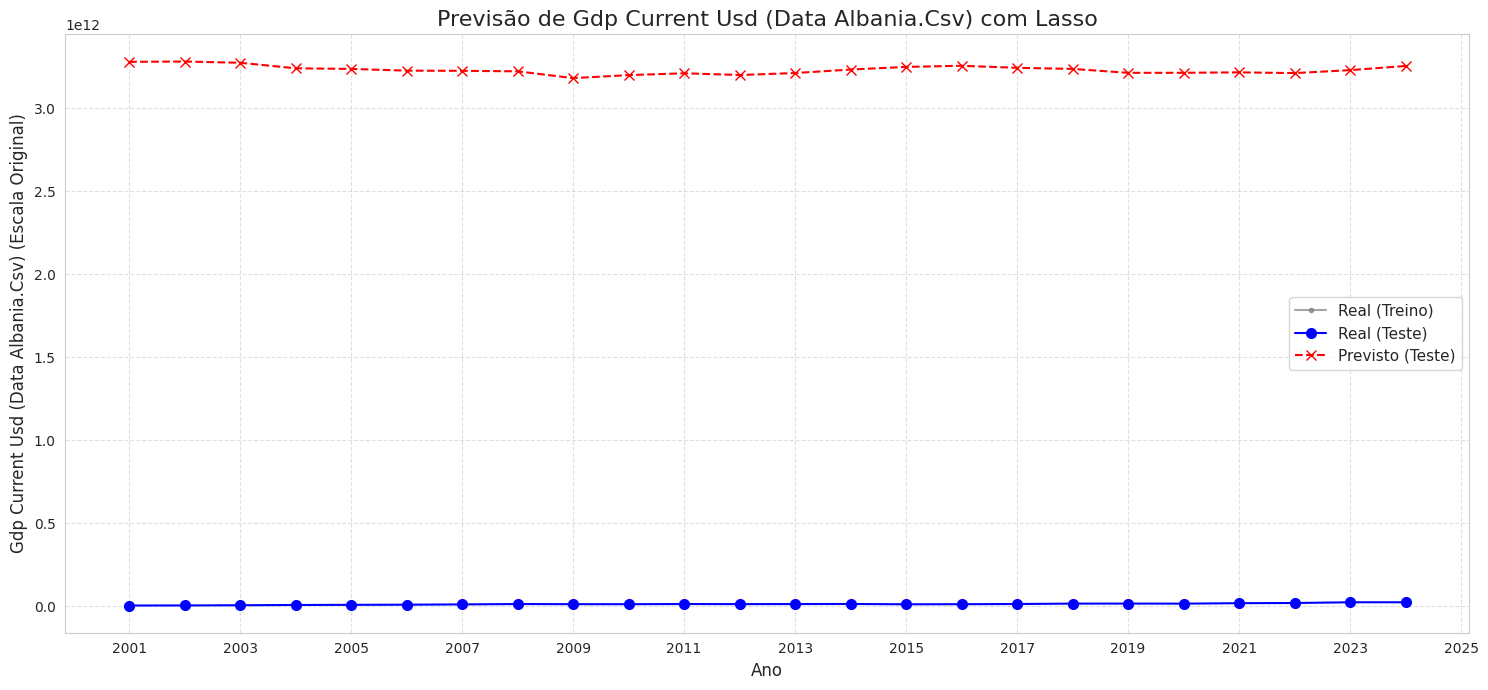


Processo de Previsão em Novos Dados Concluído.



In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# --- PREVISÃO EM NOVOS DADOS (data_albania.csv) ---
# Certifique-se que 'mml', 'model', 'x_scaler', 'y_scaler', 'X', 
# e 'TARGET_VARIABLE' estão definidos e se referem ao treino GLOBAL.

# 1. Definir o caminho para os novos dados
FILE_PATH_NEW = 'data_albania.csv' # Ou 'data_brazil.csv', etc.
print(f"\n{'='*60}")
print(f"Iniciando Previsão para Novos Dados: '{FILE_PATH_NEW}'")
print(f"{'='*60}\n")

# 2. Carregar e Preparar os Novos Dados
data_new = mml.load_and_prepare_data(FILE_PATH_NEW)

# Prosseguir apenas se os dados foram carregados
if data_new is not None:

    # 3. Aplicar Engenharia de Atributos
    X_new, y_new = mml.engineer_features(data_new, TARGET_VARIABLE)

    # Prosseguir apenas se a engenharia de atributos funcionou
    if X_new is not None:

        # 4. Alinhar Colunas
        original_feature_names = X.columns # Pega os nomes das colunas originais (GLOBAIS)
        X_new_aligned = X_new.reindex(columns=original_feature_names, fill_value=0)
        X_new_aligned = X_new_aligned.fillna(0) 

        print(f"\nAlinhamento de colunas concluído. X_new_aligned: {X_new_aligned.shape}")

        # 5. Normalizar os Novos Atributos (Usando o x_scaler *GLOBAL*)
        X_new_scaled_array = x_scaler.transform(X_new_aligned)
        X_new_scaled = pd.DataFrame(X_new_scaled_array, 
                                    columns=original_feature_names, 
                                    index=X_new_aligned.index)

        print("Novos dados normalizados.")

        # 6. Realizar Previsões (Usando o model *GLOBAL*)
        y_pred_new_scaled = model.predict(X_new_scaled)
        print("Previsões (escaladas) realizadas.")

        # 7. Reverter a Normalização das Previsões (Usando o y_scaler *GLOBAL*)
        y_pred_new_original = y_scaler.inverse_transform(y_pred_new_scaled.reshape(-1, 1)).ravel()
        predictions_series = pd.Series(y_pred_new_original, 
                                       index=X_new_scaled.index, 
                                       name=f'Predicted_{TARGET_VARIABLE}')

        print("\n--- Previsões Finais (Escala Original) ---")
        print(predictions_series.to_string())

        # 8. Avaliar se y_new existe
        if y_new is not None and not y_new.empty:
            print("\n--- Comparação com Dados Reais (se disponíveis) ---")
            
            y_new_aligned = y_new.reindex(predictions_series.index)
            valid_comparison = pd.DataFrame({'Real': y_new_aligned, 'Previsto': predictions_series}).dropna()

            if not valid_comparison.empty:
                # --- Métricas Originais ---
                mse_new = mean_squared_error(valid_comparison['Real'], valid_comparison['Previsto'])
                rmse_new = np.sqrt(mse_new)
                mape_new = mml.mean_absolute_percentage_error(valid_comparison['Real'], valid_comparison['Previsto'])

                # --- CÁLCULO NORMALIZADO (NOVO!) ---
                y_new_aligned_for_norm = valid_comparison['Real']
                # Normaliza y_new reais usando o y_scaler GLOBAL
                y_new_scaled_actual = y_scaler.transform(y_new_aligned_for_norm.values.reshape(-1, 1)).ravel()
                # Pega as previsões escaladas que correspondem aos 'Real' válidos
                y_pred_new_scaled_series = pd.Series(y_pred_new_scaled, index=X_new_scaled.index)
                y_pred_new_scaled_aligned = y_pred_new_scaled_series.reindex(y_new_aligned_for_norm.index)
                # Calcula métricas normalizadas
                mse_norm = mean_squared_error(y_new_scaled_actual, y_pred_new_scaled_aligned)
                rmse_norm = np.sqrt(mse_norm)
                # --- FIM DO CÁLCULO NORMALIZADO ---

                print("--- Métricas de Avaliação (Novos Dados) ---")
                # --- EXIBIÇÃO NORMALIZADA (NOVO!) ---
                print("   --- Escala Normalizada ---")
                print(f"      - EQM (MSE):  {mse_norm:.4f}")
                print(f"      - REQM (RMSE): {rmse_norm:.4f}")
                # --- FIM EXIBIÇÃO NORMALIZADA ---
                print("   --- Escala Original ---")
                print(f"      - EQM (MSE):  {mse_new:,.2f}")
                print(f"      - REQM (RMSE): {rmse_new:,.2f}")
                print(f"      - MAPE:       {mape_new:.2f}%")

                # 9. Visualizar
                mml.plot_predictions(pd.Series(), 
                                     valid_comparison['Real'], 
                                     valid_comparison['Previsto'], 
                                     f"{TARGET_VARIABLE} ({FILE_PATH_NEW})")
            else:
                print("Não foi possível alinhar dados reais e previstos para avaliação.")
        else:
            print("\nNão há dados reais (variável alvo) para avaliação.")

    else:
        print(f"Falha na engenharia de atributos para '{FILE_PATH_NEW}'. Previsão cancelada.")
else:
    print(f"Falha ao carregar '{FILE_PATH_NEW}'. Previsão cancelada.")

print(f"\n{'='*60}")
print("Processo de Previsão em Novos Dados Concluído.")
print(f"{'='*60}\n")


Iniciando Previsão para Novos Dados: 'data_brazil.csv'

Dados carregados de 'data_brazil.csv'.
Removendo colunas 'Unnamed': ['Unnamed: 0']
Usando 'year' como índice.

Iniciando Engenharia de Atributos...
   - Lags e Termos Polinomiais (grau 2 e 3) criados.
   - Valores ausentes/infinitos removidos (1 linhas).
Engenharia concluída. X: (24, 40), y: (24,)

Alinhamento de colunas concluído. X_new_aligned: (24, 40)
Novos dados normalizados.
Previsões (escaladas) realizadas.

--- Previsões Finais (Escala Original) ---
year
2001   -4.732195e+13
2002   -4.722642e+13
2003   -4.687880e+13
2004   -4.663317e+13
2005   -4.619409e+13
2006   -4.585199e+13
2007   -4.587175e+13
2008   -4.635735e+13
2009   -4.694952e+13
2010   -4.713563e+13
2011   -4.708697e+13
2012   -4.707859e+13
2013   -4.700722e+13
2014   -4.660352e+13
2015   -4.625800e+13
2016   -4.685896e+13
2017   -4.640524e+13
2018   -4.610283e+13
2019   -4.638392e+13
2020   -4.682133e+13
2021   -4.641744e+13
2022   -4.628843e+13
2023   -4.6433

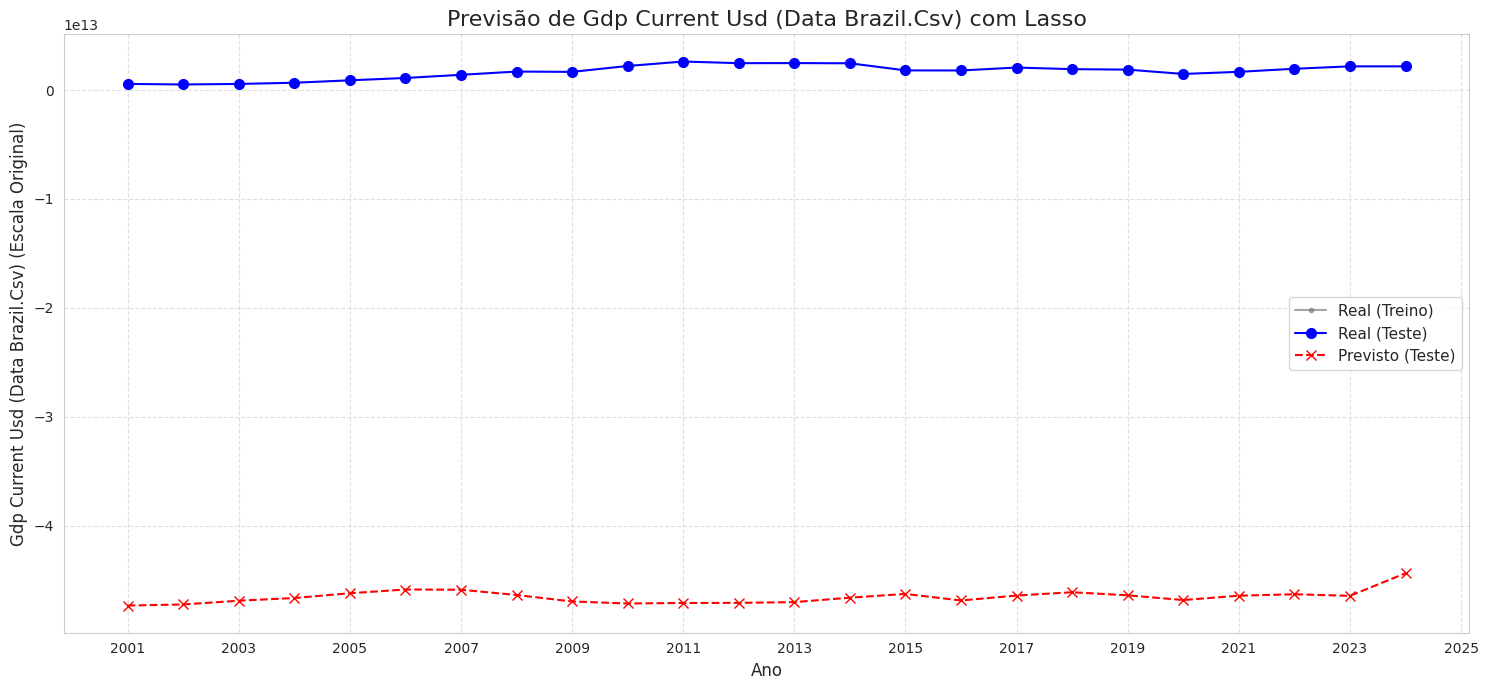

In [17]:
# 1. Definir o caminho para os novos dados
FILE_PATH_NEW = 'data_brazil.csv'
print(f"\n{'='*60}")
print(f"Iniciando Previsão para Novos Dados: '{FILE_PATH_NEW}'")
print(f"{'='*60}\n")

data_new = mml.load_and_prepare_data(FILE_PATH_NEW)

# Prosseguir apenas se os dados foram carregados
if data_new is not None:

    # 3. Aplicar Engenharia de Atributos
    X_new, y_new = mml.engineer_features(data_new, TARGET_VARIABLE)

    # Prosseguir apenas se a engenharia de atributos funcionou
    if X_new is not None:

        # 4. Alinhar Colunas
        original_feature_names = X.columns # Pega os nomes das colunas originais (GLOBAIS)
        X_new_aligned = X_new.reindex(columns=original_feature_names, fill_value=0)
        X_new_aligned = X_new_aligned.fillna(0) 

        print(f"\nAlinhamento de colunas concluído. X_new_aligned: {X_new_aligned.shape}")

        # 5. Normalizar os Novos Atributos (Usando o x_scaler *GLOBAL*)
        X_new_scaled_array = x_scaler.transform(X_new_aligned)
        X_new_scaled = pd.DataFrame(X_new_scaled_array, 
                                    columns=original_feature_names, 
                                    index=X_new_aligned.index)

        print("Novos dados normalizados.")

        # 6. Realizar Previsões (Usando o model *GLOBAL*)
        y_pred_new_scaled = model.predict(X_new_scaled)
        print("Previsões (escaladas) realizadas.")

        # 7. Reverter a Normalização das Previsões (Usando o y_scaler *GLOBAL*)
        y_pred_new_original = y_scaler.inverse_transform(y_pred_new_scaled.reshape(-1, 1)).ravel()
        predictions_series = pd.Series(y_pred_new_original, 
                                       index=X_new_scaled.index, 
                                       name=f'Predicted_{TARGET_VARIABLE}')

        print("\n--- Previsões Finais (Escala Original) ---")
        print(predictions_series.to_string())

        # 8. Avaliar se y_new existe
        if y_new is not None and not y_new.empty:
            print("\n--- Comparação com Dados Reais (se disponíveis) ---")
            
            y_new_aligned = y_new.reindex(predictions_series.index)
            valid_comparison = pd.DataFrame({'Real': y_new_aligned, 'Previsto': predictions_series}).dropna()

            if not valid_comparison.empty:
                # --- Métricas Originais ---
                mse_new = mean_squared_error(valid_comparison['Real'], valid_comparison['Previsto'])
                rmse_new = np.sqrt(mse_new)
                mape_new = mml.mean_absolute_percentage_error(valid_comparison['Real'], valid_comparison['Previsto'])

                # --- CÁLCULO NORMALIZADO (NOVO!) ---
                y_new_aligned_for_norm = valid_comparison['Real']
                # Normaliza y_new reais usando o y_scaler GLOBAL
                y_new_scaled_actual = y_scaler.transform(y_new_aligned_for_norm.values.reshape(-1, 1)).ravel()
                # Pega as previsões escaladas que correspondem aos 'Real' válidos
                y_pred_new_scaled_series = pd.Series(y_pred_new_scaled, index=X_new_scaled.index)
                y_pred_new_scaled_aligned = y_pred_new_scaled_series.reindex(y_new_aligned_for_norm.index)
                # Calcula métricas normalizadas
                mse_norm = mean_squared_error(y_new_scaled_actual, y_pred_new_scaled_aligned)
                rmse_norm = np.sqrt(mse_norm)

                print("   --- Escala Normalizada ---")
                print(f"      - EQM (MSE):  {mse_norm:.4f}")
                print(f"      - REQM (RMSE): {rmse_norm:.4f}")

                print("   --- Escala Original ---")
                print(f"      - EQM (MSE):  {mse_new:,.2f}")
                print(f"      - REQM (RMSE): {rmse_new:,.2f}")
                print(f"      - MAPE:       {mape_new:.2f}%")

                # 9. Visualizar
                mml.plot_predictions(pd.Series(), 
                                     valid_comparison['Real'], 
                                     valid_comparison['Previsto'], 
                                     f"{TARGET_VARIABLE} ({FILE_PATH_NEW})")
            else:
                print("Não foi possível alinhar dados reais e previstos para avaliação.")
        else:
            print("\nNão há dados reais (variável alvo) para avaliação.")

    else:
        print(f"Falha na engenharia de atributos para '{FILE_PATH_NEW}'. Previsão cancelada.")
else:
    print(f"Falha ao carregar '{FILE_PATH_NEW}'. Previsão cancelada.")


## Treinando e testando para cada país

In [18]:
FILE_PATH = 'data_albania.csv'
TARGET_VARIABLE = 'gdp_current_usd' # <--- ESCOLHA A COLUNA QUE VOCÊ QUER PREVER!
TRAIN_LIMIT_YEAR = 2018
LASSO_PARAMS = {'cv': 5, 'max_iter': 100000, 'n_jobs': -1, 'tol': 0.001, 'n_alphas': 10000}

print(f"Arquivo de Dados: {FILE_PATH}")
print(f"Variável Alvo:    {TARGET_VARIABLE}")
print(f"Ano Limite Treino:{TRAIN_LIMIT_YEAR}")

Arquivo de Dados: data_albania.csv
Variável Alvo:    gdp_current_usd
Ano Limite Treino:2018


Dados carregados de 'data_albania.csv'.
Removendo colunas 'Unnamed': ['Unnamed: 0']
Usando 'year' como índice.

Iniciando Engenharia de Atributos...
   - Lags e Termos Polinomiais (grau 2 e 3) criados.
   - Valores ausentes/infinitos removidos (1 linhas).
Engenharia concluída. X: (24, 40), y: (24,)

Dividindo dados em 2018 e normalizando...
   - Treino: 18, Teste: 6
Divisão e normalização concluídas.

Dividindo dados em 2018 e normalizando...
   - Treino: 18, Teste: 6
Divisão e normalização concluídas.

Treinando o Modelo LassoCV...
Treinamento concluído. Melhor Alpha (α): 0.017167

Avaliando o Modelo...
--- Resultados da Avaliação ---
   --- Escala Normalizada ---
      - EQM (MSE):  0.7683
      - REQM (RMSE): 0.8765

   --- Escala Original ---
      - EQM (MSE):  8,072,708,852,087,147,520.00
      - REQM (RMSE): 2,841,251,282.81
      - MAPE:       13.50%

Analisando os Coeficientes do Modelo...

--- Atributos Selecionados pelo Lasso ---
                                             

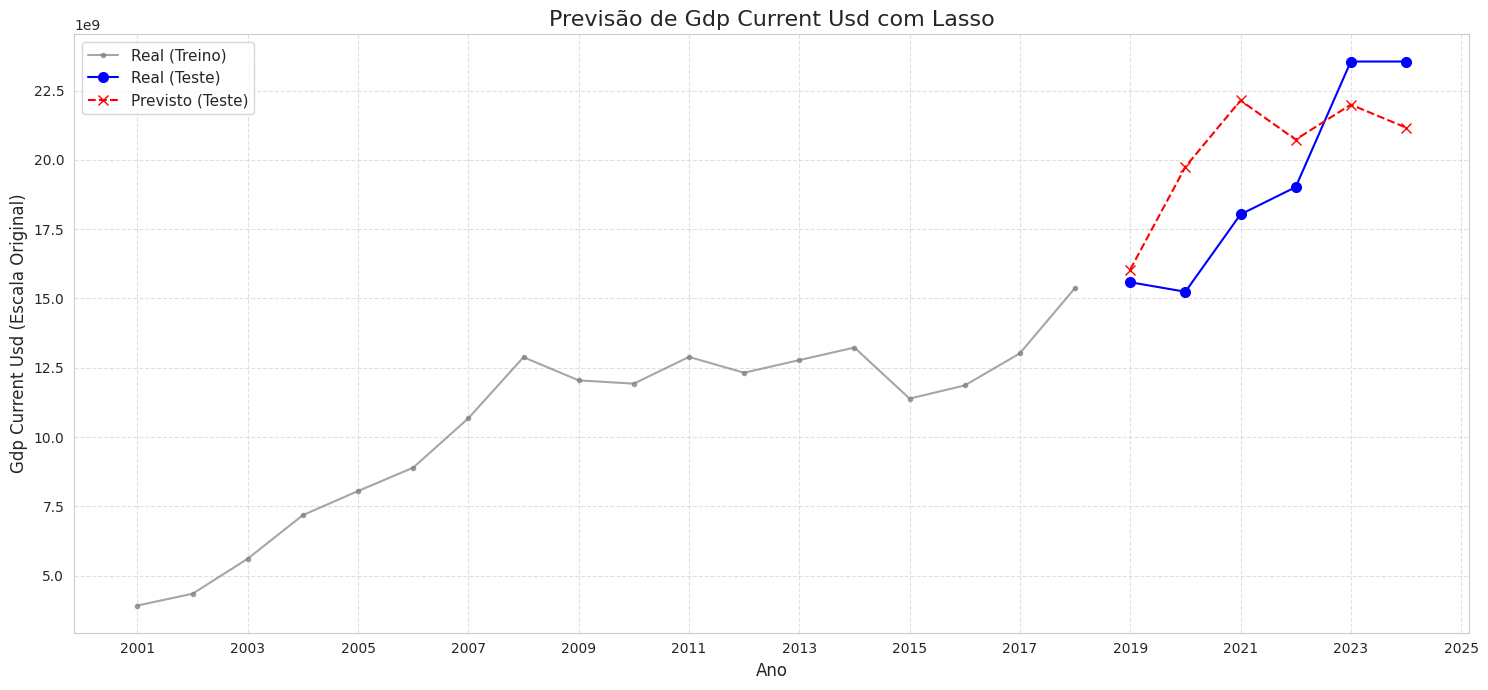


Gerando Gráfico: Importância dos Atributos...


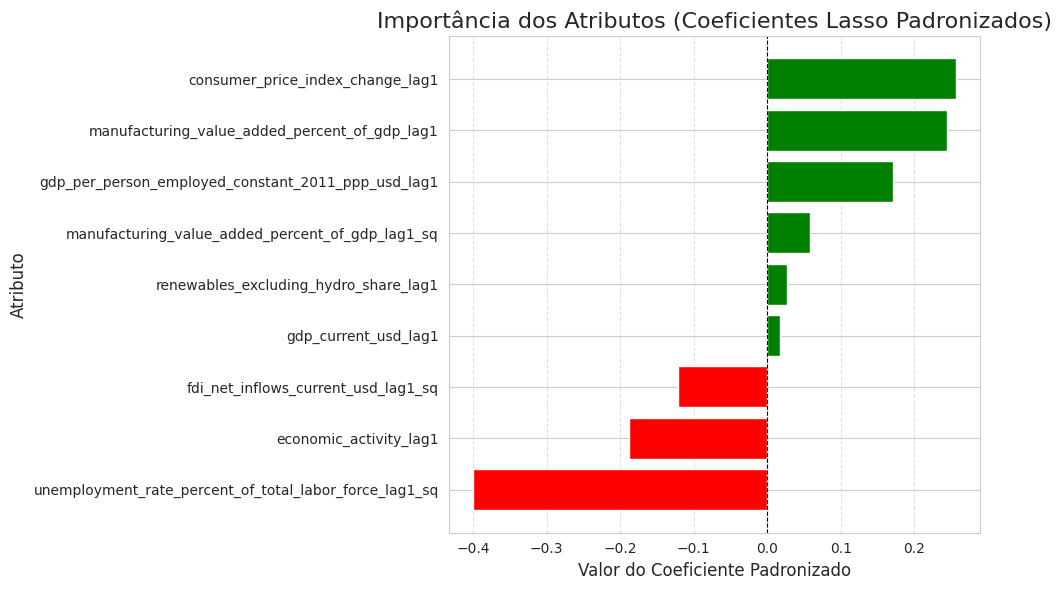

In [19]:
data = mml.load_and_prepare_data(FILE_PATH)
X, y = mml.engineer_features(data, TARGET_VARIABLE)

# 3. Divisão e Normalização (só continua se X, y foram criados)

split_result = mml.split_and_scale_data(X, y, TRAIN_LIMIT_YEAR)

# 4. Treinamento (só continua se a divisão funcionou)
(X_train_s, X_test_s, y_train_s, y_test_s,
 y_train, y_test, x_scaler, y_scaler) = mml.split_and_scale_data(X, y, TRAIN_LIMIT_YEAR)
model = mml.train_lasso_model(X_train_s, y_train_s, **LASSO_PARAMS)

# 5. Avaliação
y_pred, metrics = mml.evaluate_model(model, X_test_s, y_test, y_test_s, y_scaler)# 6. Visualização e Coeficientes
mml.display_coefficients(model, X.columns)
mml.plot_predictions(y_train, y_test, y_pred, TARGET_VARIABLE)
mml.plot_coefficients(model, X.columns)

In [20]:
FILE_PATH = 'data_brazil.csv'
TARGET_VARIABLE = 'gdp_current_usd' # <--- ESCOLHA A COLUNA QUE VOCÊ QUER PREVER!
TRAIN_LIMIT_YEAR = 2018
LASSO_PARAMS = {'cv': 5, 'max_iter': 100000, 'n_jobs': -1, 'tol': 0.001, 'n_alphas': 10000}

print(f"Arquivo de Dados: {FILE_PATH}")
print(f"Variável Alvo:    {TARGET_VARIABLE}")
print(f"Ano Limite Treino:{TRAIN_LIMIT_YEAR}")

Arquivo de Dados: data_brazil.csv
Variável Alvo:    gdp_current_usd
Ano Limite Treino:2018


Dados carregados de 'data_brazil.csv'.
Removendo colunas 'Unnamed': ['Unnamed: 0']
Usando 'year' como índice.

Iniciando Engenharia de Atributos...
   - Lags e Termos Polinomiais (grau 2 e 3) criados.
   - Valores ausentes/infinitos removidos (1 linhas).
Engenharia concluída. X: (24, 40), y: (24,)

Dividindo dados em 2018 e normalizando...
   - Treino: 18, Teste: 6
Divisão e normalização concluídas.

Dividindo dados em 2018 e normalizando...
   - Treino: 18, Teste: 6
Divisão e normalização concluídas.

Treinando o Modelo LassoCV...
Treinamento concluído. Melhor Alpha (α): 0.073728

Avaliando o Modelo...
--- Resultados da Avaliação ---
   --- Escala Normalizada ---
      - EQM (MSE):  0.1976
      - REQM (RMSE): 0.4445

   --- Escala Original ---
      - EQM (MSE):  99,464,134,986,620,106,440,704.00
      - REQM (RMSE): 315,379,350,919.84
      - MAPE:       14.19%

Analisando os Coeficientes do Modelo...

--- Atributos Selecionados pelo Lasso ---
                                       

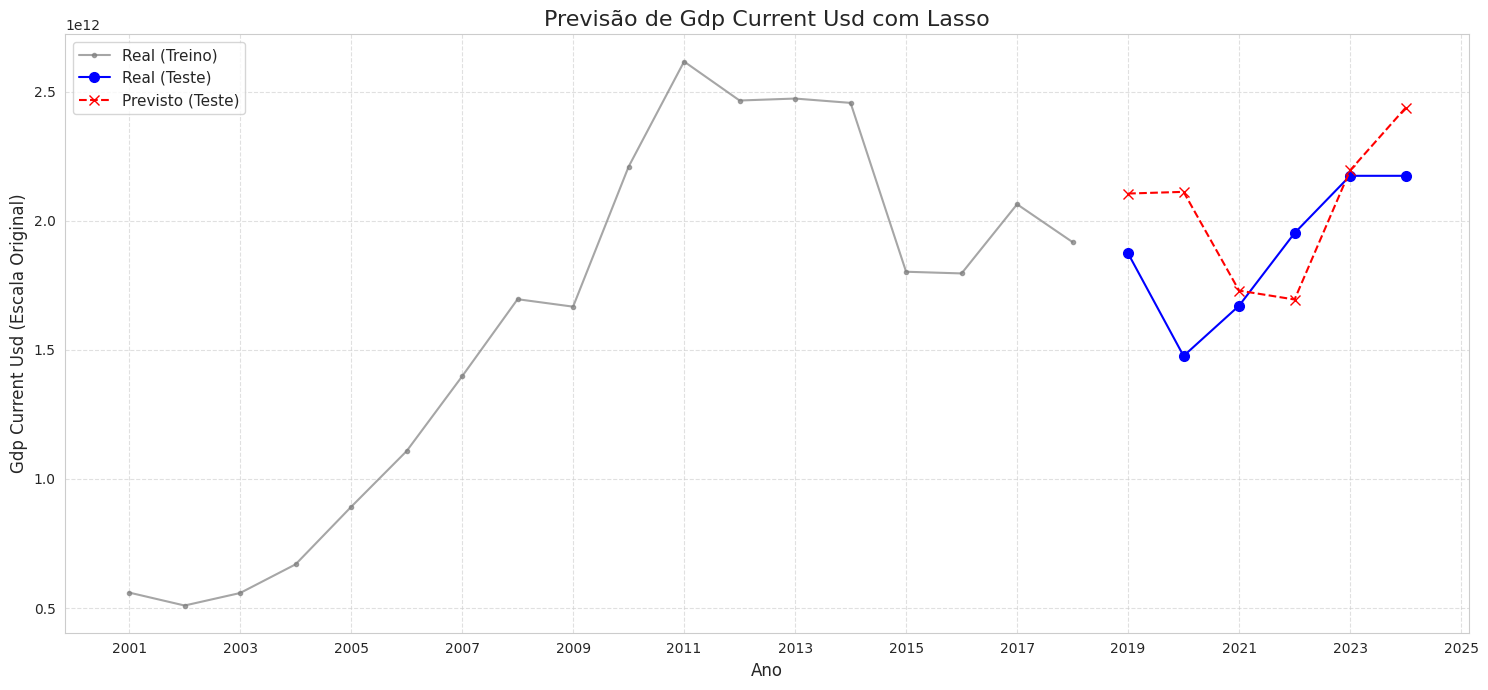


Gerando Gráfico: Importância dos Atributos...


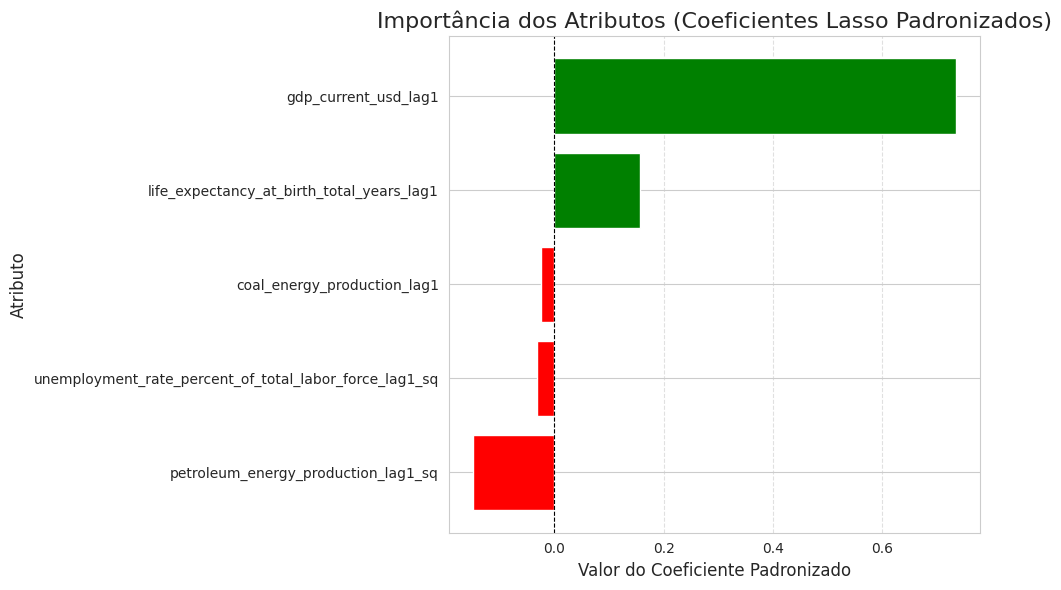

In [21]:
data = mml.load_and_prepare_data(FILE_PATH)
X, y = mml.engineer_features(data, TARGET_VARIABLE)

# 3. Divisão e Normalização (só continua se X, y foram criados)

split_result = mml.split_and_scale_data(X, y, TRAIN_LIMIT_YEAR)

# 4. Treinamento (só continua se a divisão funcionou)
(X_train_s, X_test_s, y_train_s, y_test_s,
 y_train, y_test, x_scaler, y_scaler) = mml.split_and_scale_data(X, y, TRAIN_LIMIT_YEAR)
model = mml.train_lasso_model(X_train_s, y_train_s, **LASSO_PARAMS)

# 5. Avaliação
y_pred, metrics = mml.evaluate_model(model, X_test_s, y_test, y_test_s, y_scaler)# 6. Visualização e Coeficientes
mml.display_coefficients(model, X.columns)
mml.plot_predictions(y_train, y_test, y_pred, TARGET_VARIABLE)
mml.plot_coefficients(model, X.columns)